In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [ ]:
X_in = np.array(range(1, 17)).reshape(1, 4, 4, 1).astype('float64')
kernel_in = np.array([1,2,3,4,5,6,7,8]).reshape(2,2,1,2).astype('float64')

In [ ]:
kernel_in[:,:,0,0]

array([[1., 3.],
       [5., 7.]])

In [ ]:
out = tf.nn.convolution(
    input = X_in,
    filters = kernel_in,
    strides=None,
    padding='VALID',
    data_format=None,
    dilations=None,
    name=None
)
out

<tf.Tensor: shape=(1, 3, 3, 2), dtype=float64, numpy=
array([[[[ 74.,  88.],
         [ 90., 108.],
         [106., 128.]],

        [[138., 168.],
         [154., 188.],
         [170., 208.]],

        [[202., 248.],
         [218., 268.],
         [234., 288.]]]])>

In [ ]:
out[0,:,:,0]

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[ 74.,  90., 106.],
       [138., 154., 170.],
       [202., 218., 234.]])>

In [ ]:
out[0,:,:,1]

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[ 88., 108., 128.],
       [168., 188., 208.],
       [248., 268., 288.]])>

# Image Kernel Filter

In [ ]:
image = cv2.imread('sudoku.png', cv2.IMREAD_GRAYSCALE)
data = image.astype('float64')/255
data.shape

(1280, 1280)

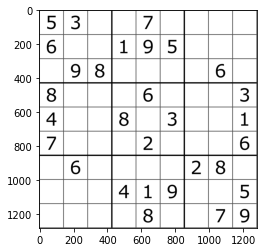

In [ ]:
plt.imshow(data, cmap = 'gray')

In [ ]:
data = data.reshape(1, data.shape[0], data.shape[1],1)
data.shape

(1, 1280, 1280, 1)

In [ ]:
sobel_x = tf.constant([[-1,0,1],[-2,0,2],[-1,0,1]], tf.float64)
sobel_y = tf.constant([[1,2,1],[0,0,0],[-1,-2,-1]], tf.float64)
laplacian = tf.constant([[0,-1,0],[-1,4,-1],[0,-1,0]], tf.float64)

sobel_x_filter = tf.reshape(sobel_x, [3,3,1,1])
sobel_y_filter = tf.reshape(sobel_y, [3,3,1,1])
laplacian_filter = tf.reshape(laplacian, [3,3,1,1])

In [ ]:
filtered_x = tf.nn.convolution(data, sobel_x_filter, strides = [1,1,1,1], padding = 'SAME')
filtered_y = tf.nn.convolution(data, sobel_y_filter, strides = [1,1,1,1], padding = 'SAME')
filtered_laplacian = tf.nn.convolution(data, laplacian_filter, strides = [1,1,1,1], padding = 'SAME')

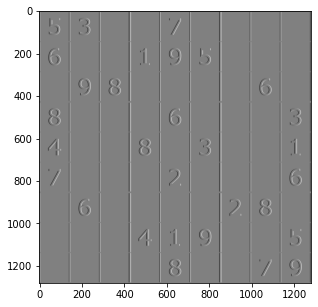

In [ ]:
plt.figure(figsize = [5,5])
plt.imshow(filtered_x[0,:,:,0], cmap = 'gray')

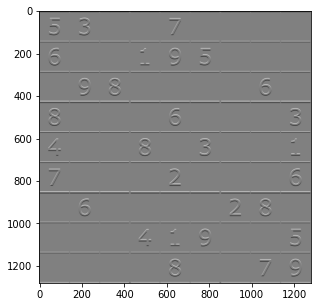

In [ ]:
plt.figure(figsize = [5,5])
plt.imshow(filtered_y[0,:,:,0], cmap = 'gray')

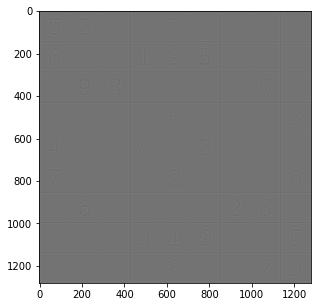

In [ ]:
plt.figure(figsize = [5,5])
plt.imshow(filtered_laplacian[0,:,:,0], cmap = 'gray')

# Convolutional Neural Network (using GradientTape)

In [ ]:
from tensorflow.keras import datasets, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
(x_train, y_train), (x_test, y_test)  = datasets.cifar10.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

170508288/170498071 [==============================] - 2s 0us/step


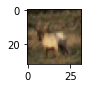

In [ ]:
plt.figure(figsize = (1,1))
plt.imshow(x_train[3])

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(64, 3, padding = 'same', activation = 'relu')
    self.pool1 = MaxPooling2D((2,2))
    self.conv2 = Conv2D(128, 3, activation = 'relu')
    self.pool2 = MaxPooling2D((2,2))
    self.conv3 = Conv2D(256, 3, activation = 'relu')
    self.flatten = Flatten()
    self.d1 = Dense(63, activation = 'relu')
    self.d2 = Dense(10, activation = 'softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyModel()

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    y_pred = model(images)
    loss = loss_fn(labels, y_pred)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, y_pred)

In [ ]:
EPOCHS = 5

for i in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  for images, labels in train_ds:
    train_step(images, labels)

  print('Epochs : %d'%(i+1))
  print('Loss : %lf'%(train_loss.result()))
  print('Accuracy : %lf'%(train_accuracy.result()))
  print('-'*30)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs : 1
Loss : 1.452767
Accuracy : 0.473360
------------------------------
Epochs : 2
Loss : 1.031619
Accuracy : 0.634640
------------------------------
Epochs : 3
Loss : 0.851452
Accuracy : 0.700160
------------------------------
Epochs : 4
Loss : 0.729729
Accuracy : 0.746100
------------------------------
Epochs : 5
Loss : 0.635408
Accuracy : 0.779140
------------------------------


In [ ]:
result = tf.math.argmax(model(x_test), axis = 1).numpy()

In [ ]:
print(classification_report(y_test, result))
print(confusion_matrix(y_test, result))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1000
           1       0.91      0.78      0.84      1000
           2       0.81      0.47      0.60      1000
           3       0.48      0.66      0.55      1000
           4       0.65      0.74      0.69      1000
           5       0.58      0.67      0.62      1000
           6       0.78      0.82      0.80      1000
           7       0.89      0.67      0.76      1000
           8       0.84      0.86      0.85      1000
           9       0.80      0.84      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000

[[781   9  14  50  21   8  15   3  68  31]
 [ 15 780   4  21   3   8   9   2  30 128]
 [ 77   2 471 114 119 100  77  18  14   8]
 [ 11   6  22 657  59 171  50   6   8  10]
 [ 13   0  28  91 740  52  36  25  13   2]
 [  8   1  11 220  38 673 

# CNN using Keras API

In [ ]:
model = tf.keras.Sequential()
model.add(Conv2D(64,3, padding = 'same', activation = 'relu', input_shape = (32,32,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(256,3, activation = 'relu'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 256)         295168    
                                                                 
 flatten_1 (Flatten)         (None, 9216)             

In [ ]:
model.compile(optimizer = 'Adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 27s 11ms/step - loss: 1.3945 - accuracy: 0.4935
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.9491 - accuracy: 0.6680
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.7693 - accuracy: 0.7327
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6546 - accuracy: 0.7726
Epoch 5/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5588 - accuracy: 0.8019
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.4662 - accuracy: 0.8364
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.3888 - accuracy: 0.8628
Epoch 8/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.3246 - accuracy: 0.8831
Epoch 9/10
1563/1563 [==============================] - 16s 11ms/step - loss: 0.2683 - accuracy: 0.9031
Epoch 10/10
1563/1563 [==============================] - 17s 11ms/step - lo

In [ ]:
result = np.argmax(model(x_test), axis = 1)

In [ ]:
print(classification_report(y_test, result))
print(confusion_matrix(y_test, result))